#### Some descriptives and transformations

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa
from statsmodels.tools.sm_exceptions import ValueWarning
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.stats.diagnostic as diagnostic
import statsmodels.tools.eval_measures as eval_measures
import statsmodels.tsa.vector_ar.var_model as var_model
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
import json
import os
import warnings
from libtad import HolidaysService
from libtad.datatypes.holidays import HolidayType

In [2]:
df = pd.read_csv("nordext_df.csv")

In [3]:
df

,Load Date,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Day of Week,Month,Year,...,HDD_Finland,CDD_Norway,CDD_Sweden,CDD_Finland,Norway_Temp_Extremes,Sweden_Temp_Extremes,Finland_Temp_Extremes,Climate_Change_Norway,Climate_Change_Sweden,Climate_Change_Finland
0,1/1/2010,19067,19703,11427,-11.30,-7.62,-15.11,Friday,January,2010,...,33.11,0.0,0.0,0.0,1,1,1,0,0,0
1,1/2/2010,19566,20316,12129,-15.99,-9.00,-19.03,Saturday,January,2010,...,37.03,0.0,0.0,0.0,1,1,1,0,0,0
2,1/3/2010,19531,20844,11925,-14.84,-12.53,-15.06,Sunday,January,2010,...,33.06,0.0,0.0,0.0,1,1,1,0,0,0
3,1/4/2010,20426,21913,12250,-12.64,-12.80,-7.33,Monday,January,2010,...,25.33,0.0,0.0,0.0,1,1,0,0,0,0
4,1/5/2010,21402,23337,12726,-19.60,-16.35,-13.74,Tuesday,January,2010,...,31.74,0.0,0.0,0.0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5108,12/27/2023,20125,18863,10688,-8.08,-8.57,-7.20,Wednesday,December,2023,...,25.20,0.0,0.0,0.0,0,1,0,0,0,0
5109,12/28/2023,20151,18044,10976,-8.64,-3.80,-4.25,Thursday,December,2023,...,22.25,0.0,0.0,0.0,0,0,0,0,0,1
5110,12/29/2023,19551,17388,11279,-8.05,-0.20,-2.93,Friday,December,2023,...,20.93,0.0,0.0,0.0,0,0,0,0,1,1
5111,12/30/2023,19033,17182,11327,-7.72,-1.63,-7.31,Saturday,December,2023,...,25.31,0.0,0.0,0.0,0,0,0,0,1,0


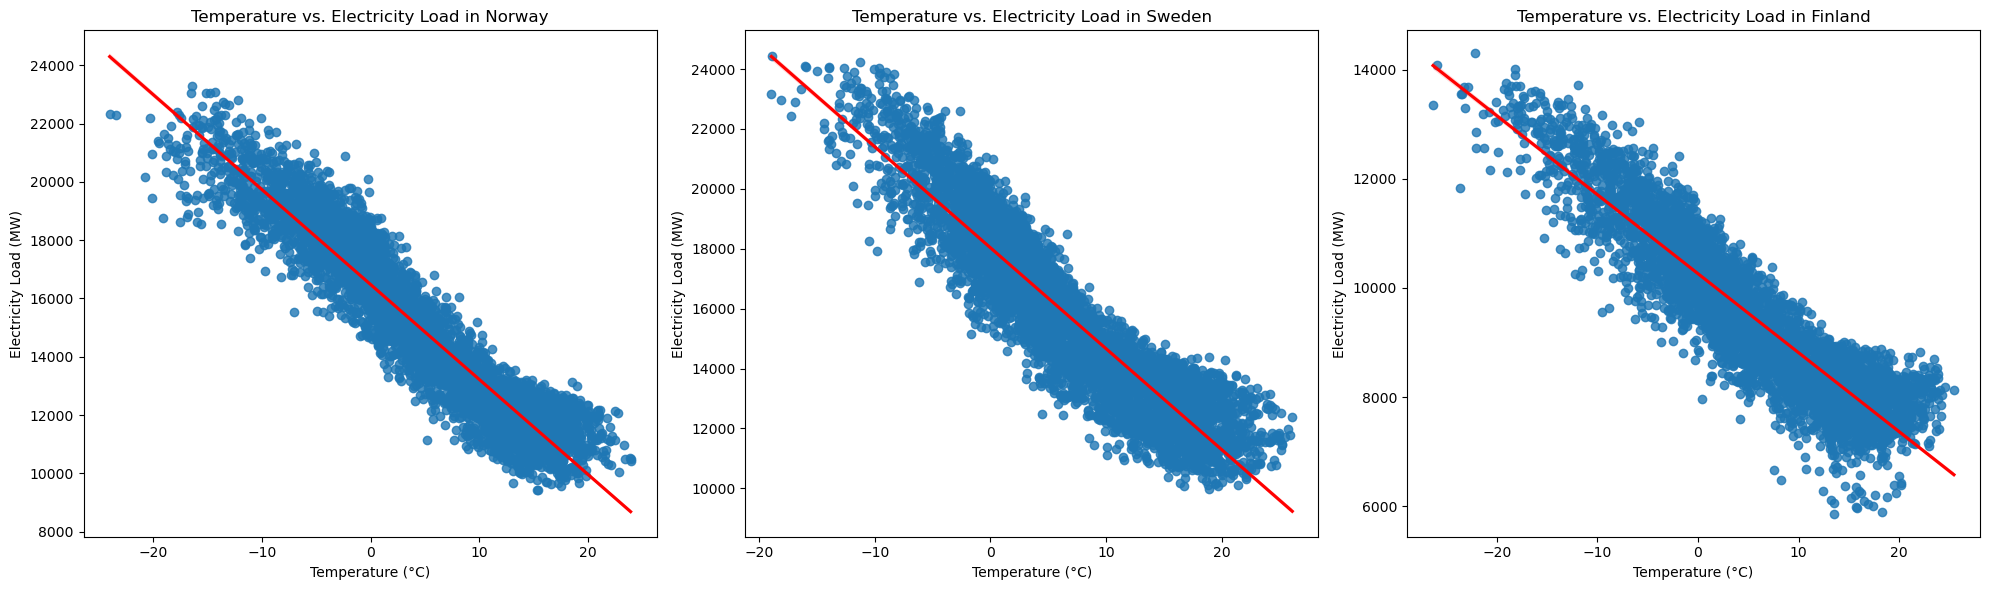

In [4]:
plt.figure(figsize=[20, 6])

# Temperature vs Electricity Load in Norway
plt.subplot(1, 3, 1)
sns.regplot(x='Temp - Norway', y='Total Load [MW] - Norway', data=df, line_kws={"color": "red"})
plt.title('Temperature vs. Electricity Load in Norway')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')

# Temperature vs Electricity Load in Sweden
plt.subplot(1, 3, 2)
sns.regplot(x='Temp - Sweden', y='Total Load [MW] - Sweden', data=df, line_kws={"color": "red"})
plt.title('Temperature vs. Electricity Load in Sweden')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')

# Temperature vs Electricity Load in Finland
plt.subplot(1, 3, 3)
sns.regplot(x='Temp - Finland', y='Total Load [MW] - Finland', data=df, line_kws={"color": "red"})
plt.title('Temperature vs. Electricity Load in Finland')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')

plt.tight_layout()
plt.show()

In [5]:
# Converting 'Load Date' column into datetime format
df['Load Date'] = pd.to_datetime(df['Load Date'])

# Setting the 'Load Date' as the index of the DataFrame
df.set_index('Load Date', inplace=True)

# Creating new columns for calendar features
df['Day of Week'] = df.index.day_name()  # Day of the week
df['Month'] = df.index.month_name()  # Month of the year
df['Year'] = df.index.year  # Year

# Displaying the first few rows to confirm changes
df.head()

,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Day of Week,Month,Year,Holiday_Norway,...,HDD_Finland,CDD_Norway,CDD_Sweden,CDD_Finland,Norway_Temp_Extremes,Sweden_Temp_Extremes,Finland_Temp_Extremes,Climate_Change_Norway,Climate_Change_Sweden,Climate_Change_Finland
Load Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,19067,19703,11427,-11.30,-7.62,-15.11,Friday,January,2010,1,...,33.11,0.0,0.0,0.0,1,1,1,0,0,0
2010-01-02,19566,20316,12129,-15.99,-9.00,-19.03,Saturday,January,2010,0,...,37.03,0.0,0.0,0.0,1,1,1,0,0,0
2010-01-03,19531,20844,11925,-14.84,-12.53,-15.06,Sunday,January,2010,0,...,33.06,0.0,0.0,0.0,1,1,1,0,0,0
2010-01-04,20426,21913,12250,-12.64,-12.80,-7.33,Monday,January,2010,0,...,25.33,0.0,0.0,0.0,1,1,0,0,0,0
2010-01-05,21402,23337,12726,-19.60,-16.35,-13.74,Tuesday,January,2010,0,...,31.74,0.0,0.0,0.0,1,1,1,0,0,0


In [6]:
# Specifying the path to my folder
my_plots = 'E:\ACADEMICS\THESIS\Thesis_all_plots\general_plots'

In [7]:
df.columns

Index(['Total Load [MW] - Norway', 'Total Load [MW] - Sweden',
       'Total Load [MW] - Finland', 'Temp - Norway', 'Temp - Sweden',
       'Temp - Finland', 'Day of Week', 'Month', 'Year', 'Holiday_Norway',
       'Holiday_Sweden', 'Holiday_Finland', 'HDD_Norway', 'HDD_Sweden',
       'HDD_Finland', 'CDD_Norway', 'CDD_Sweden', 'CDD_Finland',
       'Norway_Temp_Extremes', 'Sweden_Temp_Extremes', 'Finland_Temp_Extremes',
       'Climate_Change_Norway', 'Climate_Change_Sweden',
       'Climate_Change_Finland'],
      dtype='object')

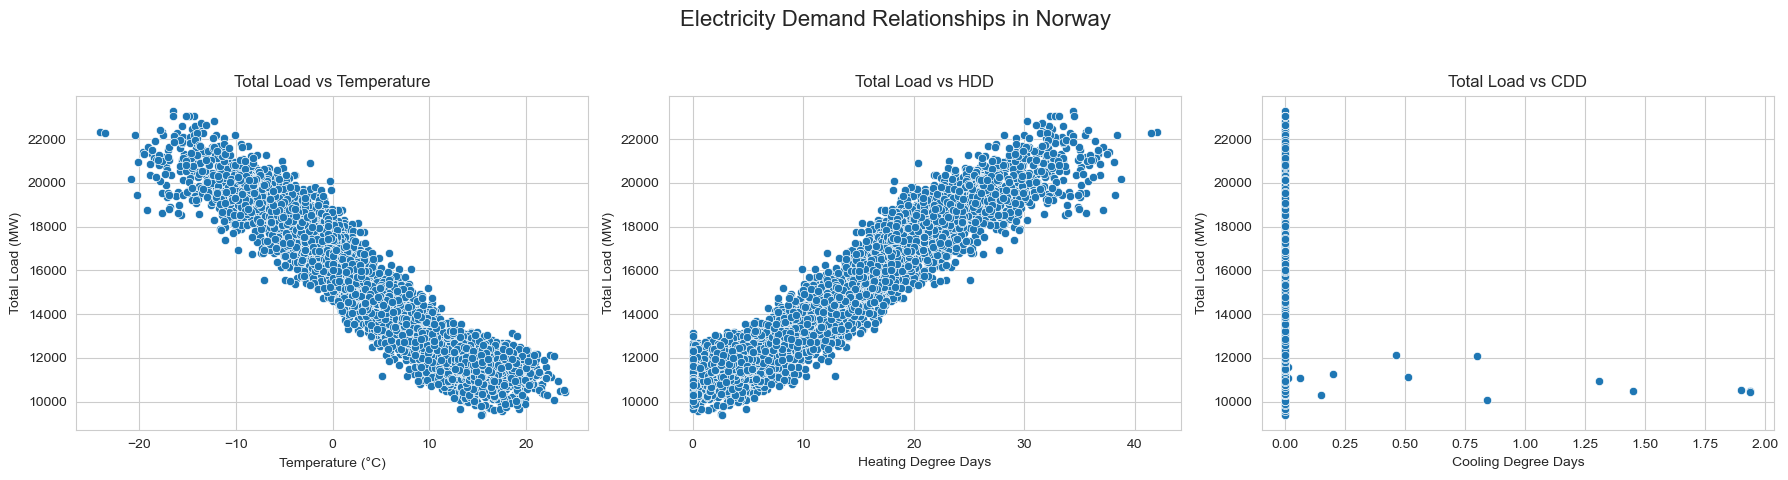

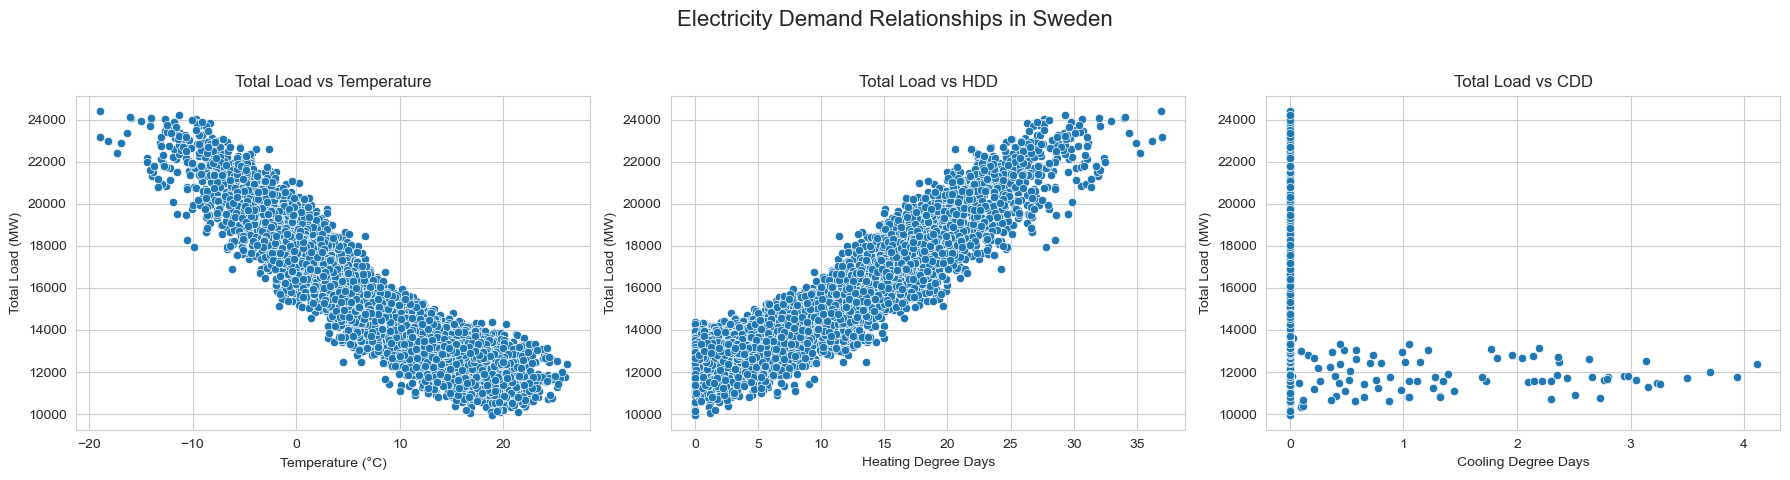

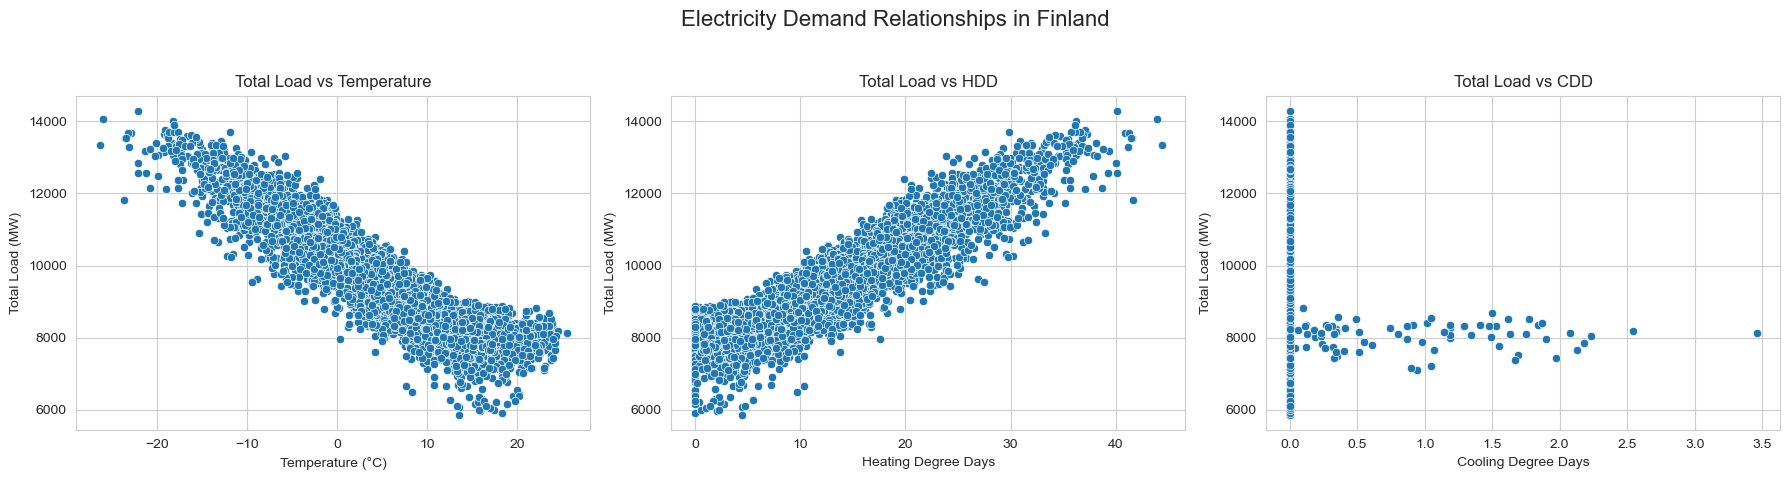

In [8]:
# Setting the aesthetics for the plots
sns.set_style("whitegrid")

# Defining a function to create scatter plots for Total Load vs Temperature and HDD
def plot_relationships(country, load_column, temp_column, hdd_column, cdd_column):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Electricity Demand Relationships in {country}', fontsize=16)
    
    # Total Load vs Temperature
    sns.scatterplot(ax=axes[0], data=df, x=temp_column, y=load_column)
    axes[0].set_title('Total Load vs Temperature')
    axes[0].set_xlabel('Temperature (°C)')
    axes[0].set_ylabel('Total Load (MW)')
    
    # Total Load vs HDD
    sns.scatterplot(ax=axes[1], data=df, x=hdd_column, y=load_column)
    axes[1].set_title('Total Load vs HDD')
    axes[1].set_xlabel('Heating Degree Days')
    axes[1].set_ylabel('Total Load (MW)')

    # Total Load vs CDD
    sns.scatterplot(ax=axes[2], data=df, x=cdd_column, y=load_column)
    axes[2].set_title('Total Load vs CDD')
    axes[2].set_xlabel('Cooling Degree Days')
    axes[2].set_ylabel('Total Load (MW)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Plotting relationships for each country
plot_relationships('Norway', 'Total Load [MW] - Norway', 'Temp - Norway', 'HDD_Norway', 'CDD_Norway')
plot_relationships('Sweden', 'Total Load [MW] - Sweden', 'Temp - Sweden', 'HDD_Sweden', 'CDD_Sweden')
plot_relationships('Finland', 'Total Load [MW] - Finland', 'Temp - Finland', 'HDD_Finland', 'CDD_Finland')

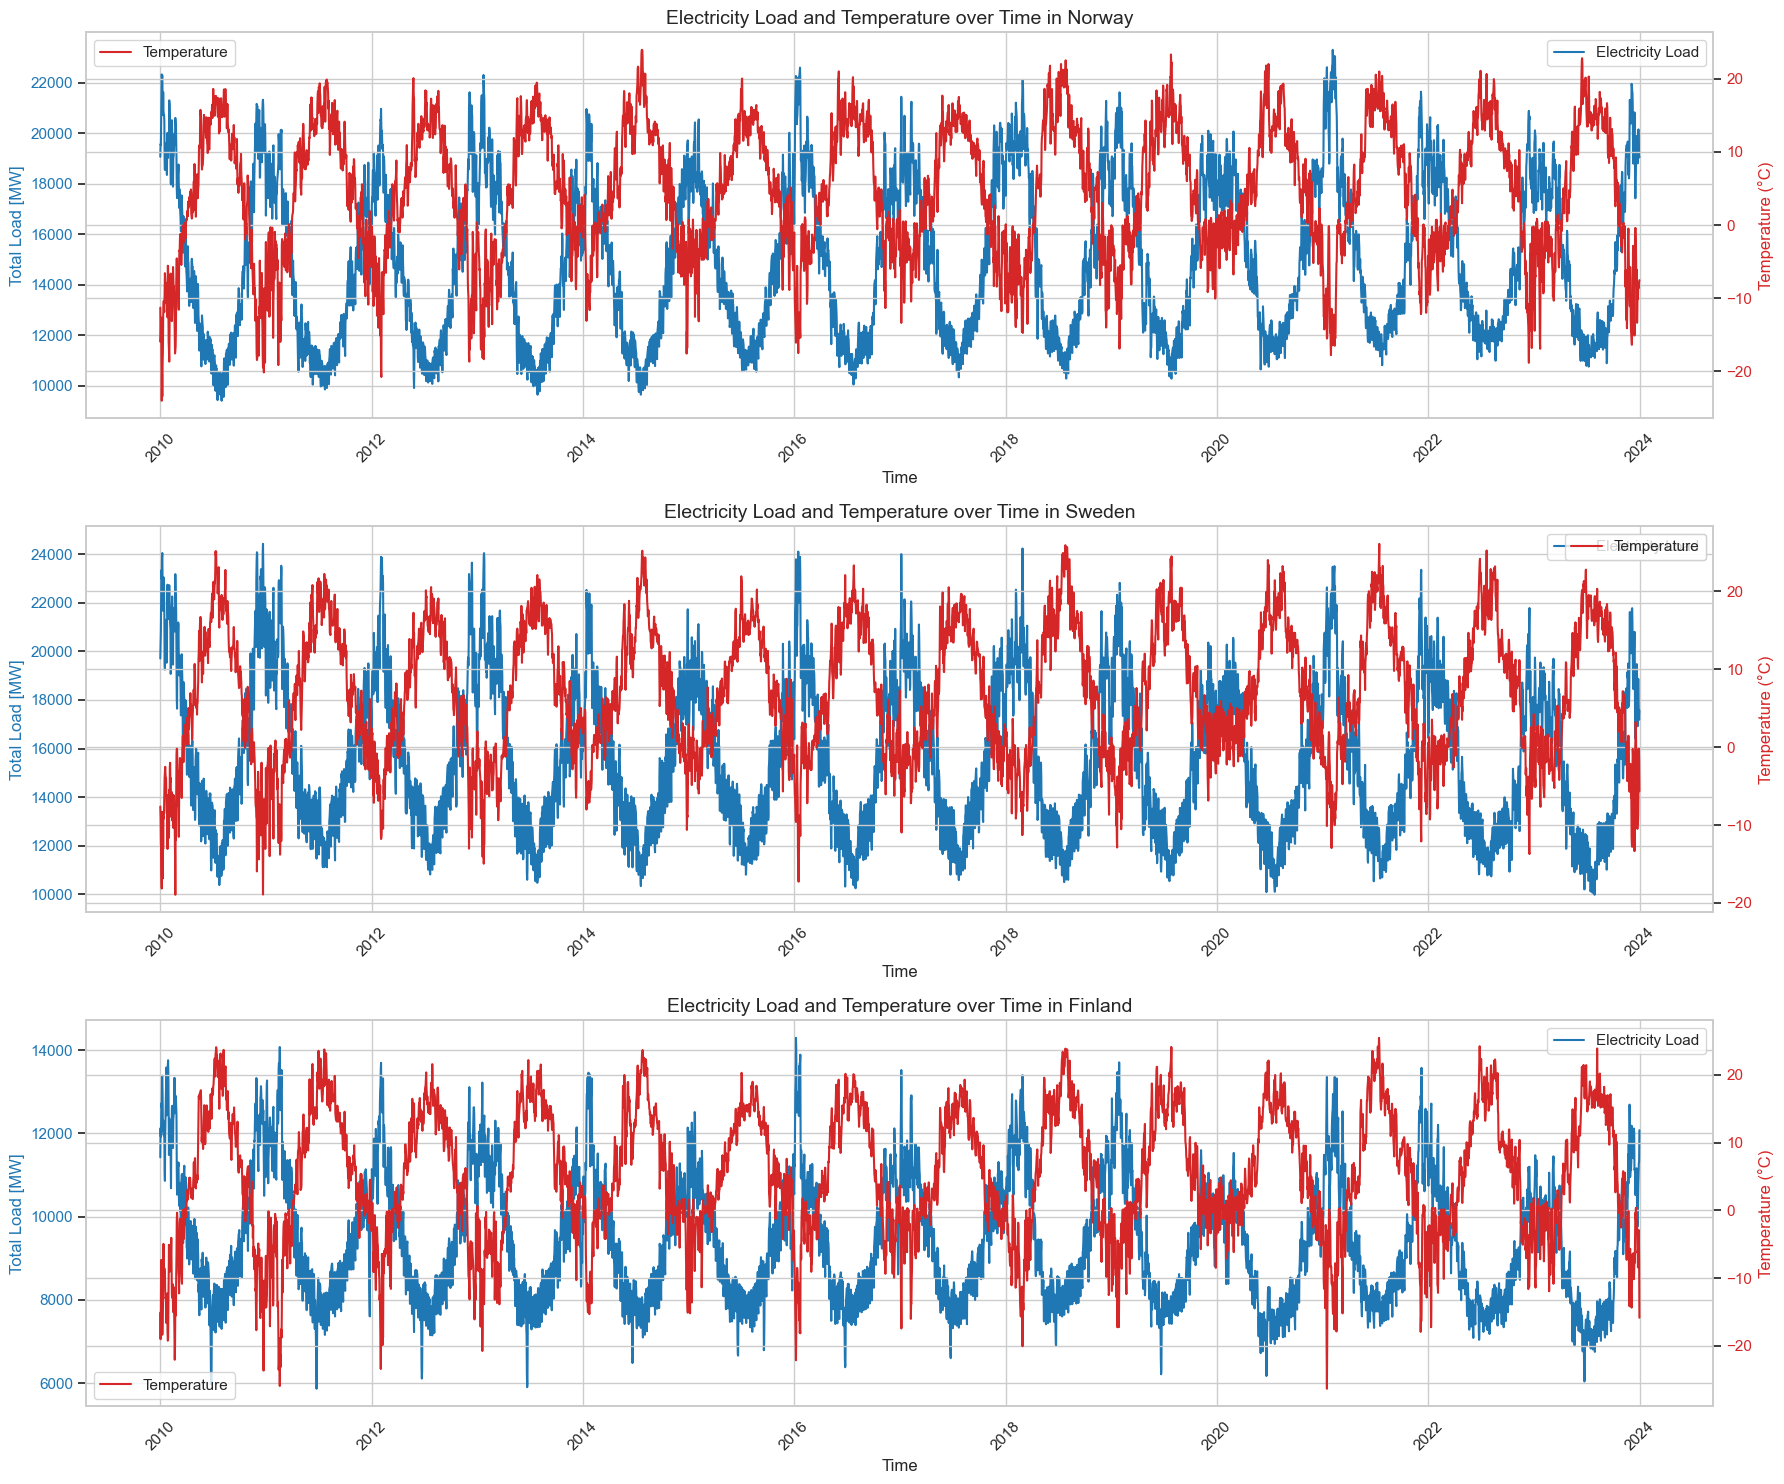

In [9]:
# Setting the style
sns.set(style="whitegrid")

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(18, 15))  # Adjusted to 3 rows, 1 column

# Function to plot both electricity load and temperature
def plot_load_and_temp(ax, country):
    color = 'tab:blue'
    ax.set_title(f'Electricity Load and Temperature over Time in {country}', fontsize=14)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Total Load [MW]', color=color, fontsize=12)
    sns.lineplot(ax=ax, x=df.index, y=f"Total Load [MW] - {country}", data=df, label='Electricity Load', color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.tick_params(axis='x', rotation=45)

    ax_temp = ax.twinx()  # Instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax_temp.set_ylabel('Temperature (°C)', color=color, fontsize=12)  # we already handled the x-label with ax1
    sns.lineplot(ax=ax_temp, x=df.index, y=f"Temp - {country}", data=df, label='Temperature', color=color)
    ax_temp.tick_params(axis='y', labelcolor=color)

# Norway
plot_load_and_temp(axes[0], 'Norway')

# Sweden
plot_load_and_temp(axes[1], 'Sweden')

# Finland
plot_load_and_temp(axes[2], 'Finland')

plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'plot1.png'), dpi = 1000)  # Save as PNG format
plt.show()


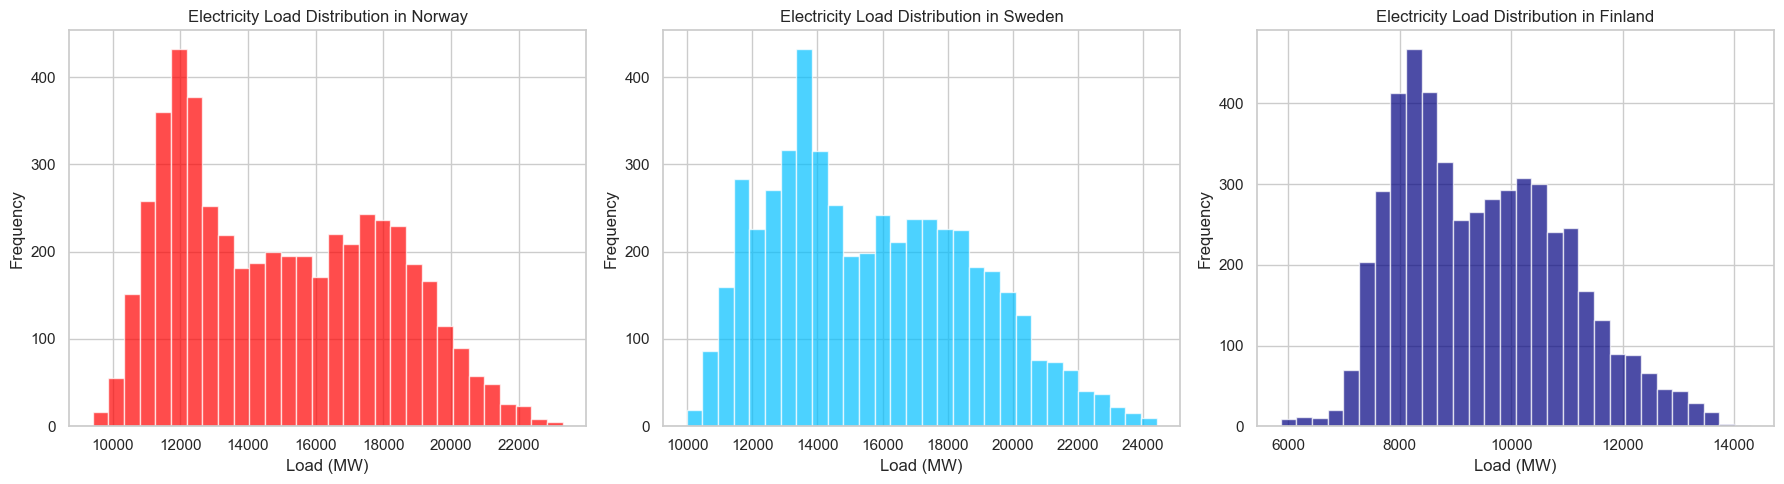

In [10]:
# Plotting histograms for the load data for Norway, Sweden, and Finland to visualize skewness
plt.figure(figsize=(18, 5))

# Histogram for Norway
plt.subplot(1, 3, 1)
plt.hist(df['Total Load [MW] - Norway'], bins=30, color='red', alpha=0.7)
plt.title('Electricity Load Distribution in Norway')
plt.xlabel('Load (MW)')
plt.ylabel('Frequency')

# Histogram for Sweden
plt.subplot(1, 3, 2)
plt.hist(df['Total Load [MW] - Sweden'], bins=30, color='deepskyblue', alpha=0.7)
plt.title('Electricity Load Distribution in Sweden')
plt.xlabel('Load (MW)')
plt.ylabel('Frequency')

# Histogram for Finland
plt.subplot(1, 3, 3)
plt.hist(df['Total Load [MW] - Finland'], bins=30, color='navy', alpha=0.7)
plt.title('Electricity Load Distribution in Finland')
plt.xlabel('Load (MW)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'skew.png'), dpi = 600)  # Save as PNG format
plt.show()

In [11]:
# Calculating skewness for the load data for each country
skewness = df[['Total Load [MW] - Norway', 'Total Load [MW] - Sweden', 'Total Load [MW] - Finland']].skew()

skewness


Total Load [MW] - Norway     0.310587
Total Load [MW] - Sweden     0.400477
Total Load [MW] - Finland    0.460134
dtype: float64

In [12]:
# Calculating skewness for the temperature data for each country
temperature_skewness = df[['Temp - Norway', 'Temp - Sweden', 'Temp - Finland']].skew()

temperature_skewness

Temp - Norway    -0.259311
Temp - Sweden    -0.066171
Temp - Finland   -0.245828
dtype: float64

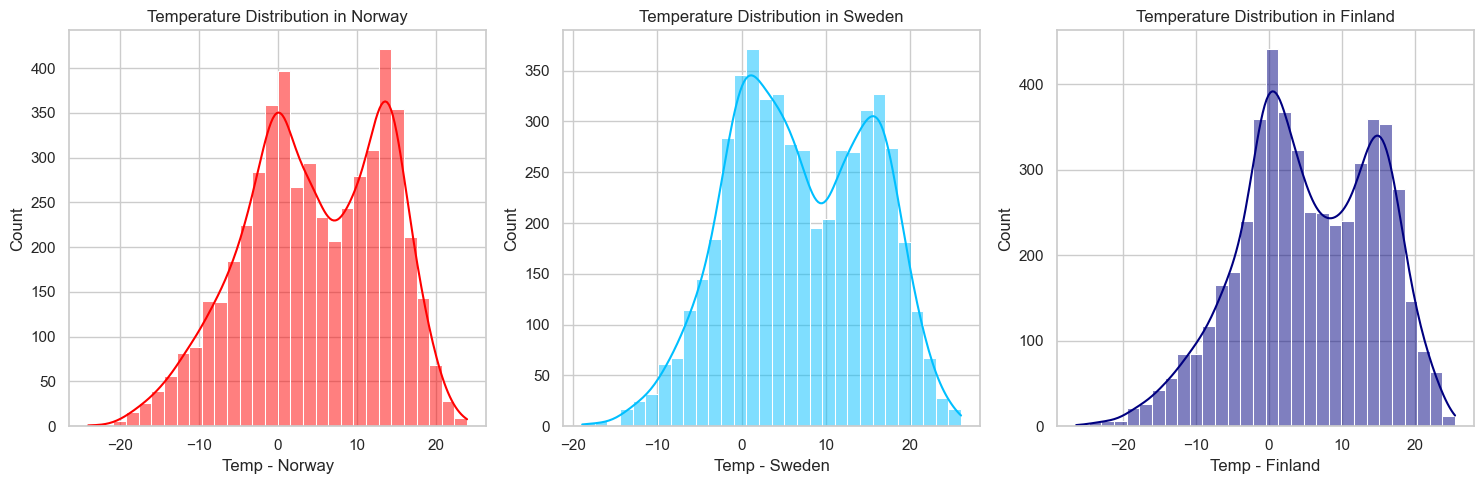

In [13]:
# Setting the style for seaborn plots
sns.set(style="whitegrid")

# Plotting the distribution of temperatures for each country
plt.figure(figsize=(15, 5))

# Norway
plt.subplot(1, 3, 1)
sns.histplot(df['Temp - Norway'], bins=30, kde=True, color="red")
plt.title('Temperature Distribution in Norway')

# Sweden
plt.subplot(1, 3, 2)
sns.histplot(df['Temp - Sweden'], bins=30, kde=True, color="deepskyblue")
plt.title('Temperature Distribution in Sweden')

# Finland
plt.subplot(1, 3, 3)
sns.histplot(df['Temp - Finland'], bins=30, kde=True, color="navy")
plt.title('Temperature Distribution in Finland')

plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'plot2.png'), dpi = 600)  # Save as PNG format
plt.show()

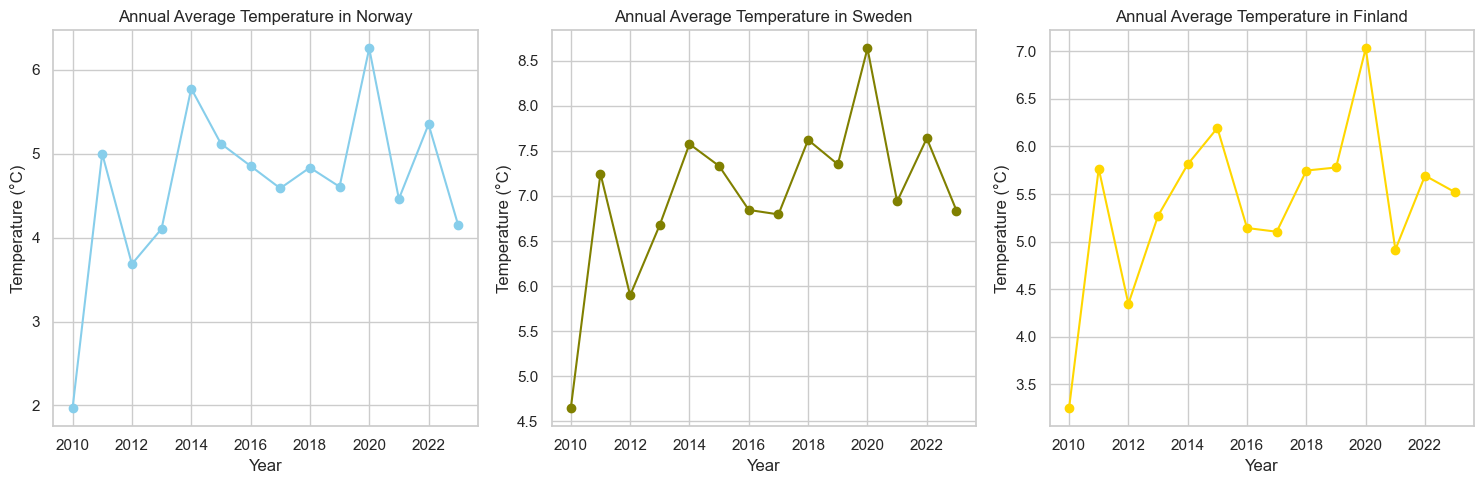

In [14]:
# Calculate yearly average temperature for each country
yearly_avg_temp = df.groupby('Year').agg({
    'Temp - Norway': 'mean',
    'Temp - Sweden': 'mean',
    'Temp - Finland': 'mean'
}).reset_index()

# Plotting the annual average temperatures
plt.figure(figsize=(15, 5))

# Plot for Norway
plt.subplot(1, 3, 1)
plt.plot(yearly_avg_temp['Year'], yearly_avg_temp['Temp - Norway'], marker='o', linestyle='-', color='skyblue')
plt.title('Annual Average Temperature in Norway')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')

# Plot for Sweden
plt.subplot(1, 3, 2)
plt.plot(yearly_avg_temp['Year'], yearly_avg_temp['Temp - Sweden'], marker='o', linestyle='-', color='olive')
plt.title('Annual Average Temperature in Sweden')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')

# Plot for Finland
plt.subplot(1, 3, 3)
plt.plot(yearly_avg_temp['Year'], yearly_avg_temp['Temp - Finland'], marker='o', linestyle='-', color='gold')
plt.title('Annual Average Temperature in Finland')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')

plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'plot3.png'), dpi = 600)  # Save as PNG format
plt.show()

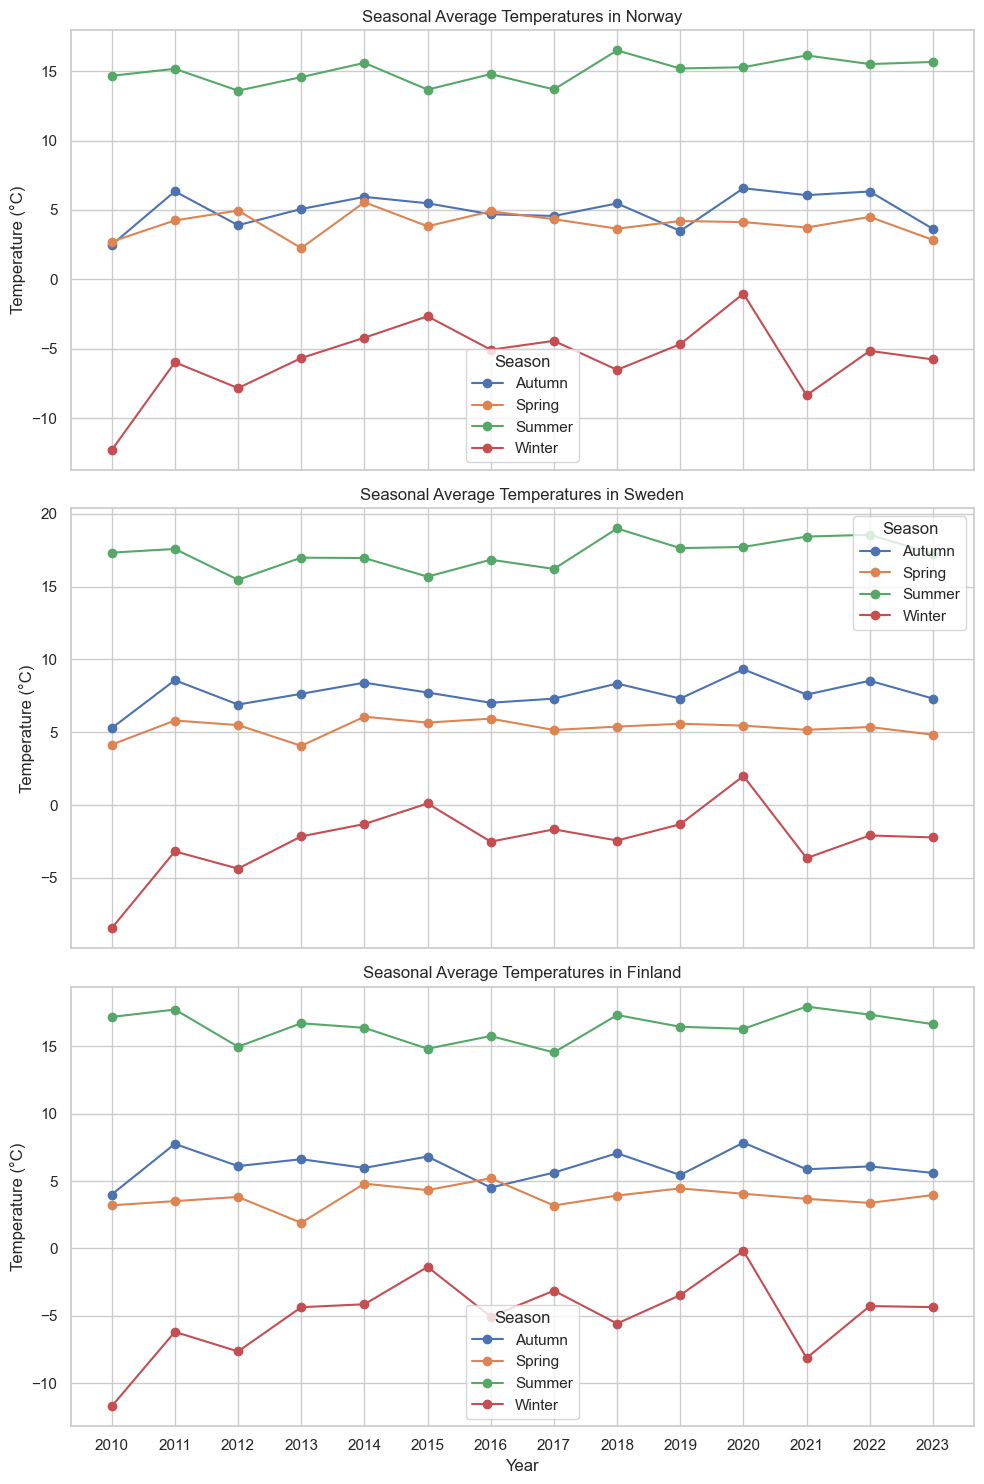

In [15]:
# Mapping each month to a meteorological season
month_to_season = {
    1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn',
    12: 'Winter'
}

# Converting 'Month' to actual month numbers since it's in words
df['Month'] = pd.to_datetime(df['Month'], format='%B').dt.month  

# Assigning seasons based on the month
df['Season'] = df['Month'].map(month_to_season)

# Calculating the average temperature for each season of each year for each country
seasonal_avg_temp = df.groupby(['Year', 'Season']).agg({
    'Temp - Norway': 'mean',
    'Temp - Sweden': 'mean',
    'Temp - Finland': 'mean'
}).reset_index()

# Pivoting the DataFrame for easier plotting
seasonal_avg_temp_pivot = seasonal_avg_temp.pivot(index='Year', columns='Season', values=['Temp - Norway', 'Temp - Sweden', 'Temp - Finland'])

# Plotting
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

countries = ['Norway', 'Sweden', 'Finland']

for i, country in enumerate(countries):
    seasonal_avg_temp_pivot[('Temp - ' + country)].plot(ax=axes[i], marker='o')
    axes[i].set_title(f'Seasonal Average Temperatures in {country}')
    axes[i].set_ylabel('Temperature (°C)')
    axes[i].legend(title='Season')

plt.xlabel('Year')
plt.xticks(np.arange(min(df['Year']), max(df['Year'])+1, 1.0))  # Assuming 'Year' is in a suitable format
plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'plot4.png'), dpi = 600)  # Save as PNG format
plt.show()


In [16]:
# Calculating the minimum (extreme low) and maximum (extreme high) temperatures for each country
extreme_temps = df[['Temp - Norway', 'Temp - Sweden', 'Temp - Finland']].agg(['min', 'max']).T

# Renaming columns for clarity
extreme_temps.columns = ['Extreme_Low_Temp', 'Extreme_High_Temp']

extreme_temps

,Extreme_Low_Temp,Extreme_High_Temp
Temp - Norway,-24.02,23.94
Temp - Sweden,-18.95,26.11
Temp - Finland,-26.35,25.46


In [17]:
# Calculating the 5th and 95th percentiles for the temperature distributions of each country
percentiles = df[['Temp - Norway', 'Temp - Sweden', 'Temp - Finland']].agg([lambda x: x.quantile(0.05), lambda x: x.quantile(0.95)])
percentiles.index = ['5th Percentile', '95th Percentile']

percentiles

,Temp - Norway,Temp - Sweden,Temp - Finland
5th Percentile,-10.77,-6.300,-10.588
95th Percentile,17.51,19.852,19.144


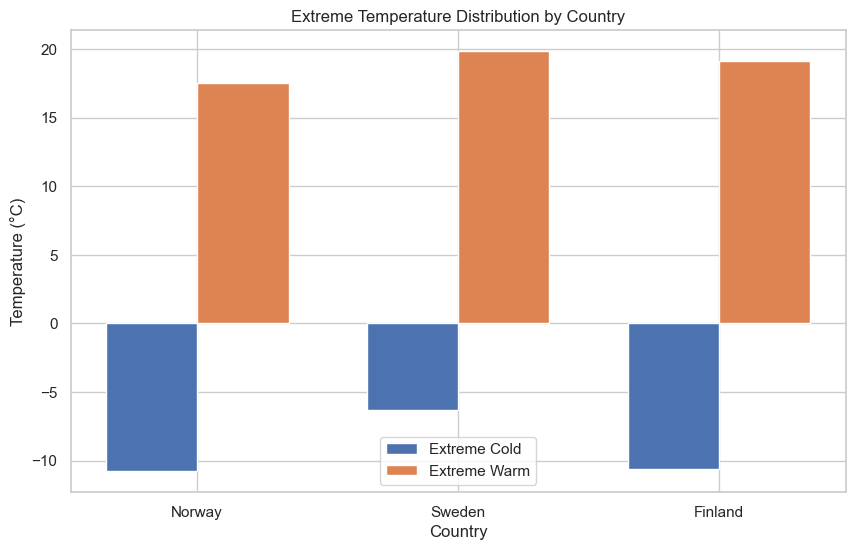

In [18]:

# Preparing data for plotting
countries = ['Norway', 'Sweden', 'Finland']
percentile_5th = percentiles.loc['5th Percentile'].values
percentile_95th = percentiles.loc['95th Percentile'].values

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(countries))

bars1 = ax.bar(index, percentile_5th, bar_width, label='Extreme Cold')
bars2 = ax.bar([p + bar_width for p in index], percentile_95th, bar_width, label='Extreme Warm')

ax.set_xlabel('Country')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Extreme Temperature Distribution by Country')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(countries)
ax.legend()
plt.savefig(os.path.join(my_plots, 'plot5.png'), dpi = 600)  # Save as PNG format

plt.show()

In [19]:
df

,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Day of Week,Month,Year,Holiday_Norway,...,CDD_Norway,CDD_Sweden,CDD_Finland,Norway_Temp_Extremes,Sweden_Temp_Extremes,Finland_Temp_Extremes,Climate_Change_Norway,Climate_Change_Sweden,Climate_Change_Finland,Season
Load Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,19067,19703,11427,-11.30,-7.62,-15.11,Friday,1,2010,1,...,0.0,0.0,0.0,1,1,1,0,0,0,Winter
2010-01-02,19566,20316,12129,-15.99,-9.00,-19.03,Saturday,1,2010,0,...,0.0,0.0,0.0,1,1,1,0,0,0,Winter
2010-01-03,19531,20844,11925,-14.84,-12.53,-15.06,Sunday,1,2010,0,...,0.0,0.0,0.0,1,1,1,0,0,0,Winter
2010-01-04,20426,21913,12250,-12.64,-12.80,-7.33,Monday,1,2010,0,...,0.0,0.0,0.0,1,1,0,0,0,0,Winter
2010-01-05,21402,23337,12726,-19.60,-16.35,-13.74,Tuesday,1,2010,0,...,0.0,0.0,0.0,1,1,1,0,0,0,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,20125,18863,10688,-8.08,-8.57,-7.20,Wednesday,12,2023,0,...,0.0,0.0,0.0,0,1,0,0,0,0,Winter
2023-12-28,20151,18044,10976,-8.64,-3.80,-4.25,Thursday,12,2023,0,...,0.0,0.0,0.0,0,0,0,0,0,1,Winter
2023-12-29,19551,17388,11279,-8.05,-0.20,-2.93,Friday,12,2023,0,...,0.0,0.0,0.0,0,0,0,0,1,1,Winter


In [20]:
# Calculating the 5th and 95th percentiles for each country
percentile_values = {
    'Norway': {
        '5th': df['Temp - Norway'].quantile(0.05),
        '95th': df['Temp - Norway'].quantile(0.95)
    },
    'Sweden': {
        '5th': df['Temp - Sweden'].quantile(0.05),
        '95th': df['Temp - Sweden'].quantile(0.95)
    },
    'Finland': {
        '5th': df['Temp - Finland'].quantile(0.05),
        '95th': df['Temp - Finland'].quantile(0.95)
    }
}

# Creating binary indicators and combine into a single column for extreme temperature conditions
for country in ['Norway', 'Sweden', 'Finland']:
    temp_col = f'Temp - {country}'
    cold_extremes_col = f'{country}_Cold_Extremes'
    hot_extremes_col = f'{country}_Hot_Extremes'
    extremes_col = f'{country}_Temp_Extremes'
    
    # Calculate binary indicators for cold and hot extremes
    df[cold_extremes_col] = (df[temp_col] < percentile_values[country]['5th']).astype(int)
    df[hot_extremes_col] = (df[temp_col] > percentile_values[country]['95th']).astype(int)
    
    # Combine cold and hot indicators into a single column
    # 0: Not extreme, 1: Cold extreme, 2: Hot extreme
    df[extremes_col] = df[cold_extremes_col] + (df[hot_extremes_col] * 2)
    
    # Drop the intermediate binary indicator columns
    df.drop(columns=[cold_extremes_col, hot_extremes_col], inplace=True)

# Display the first few rows to confirm the new columns are added correctly
df.head()


,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Day of Week,Month,Year,Holiday_Norway,...,CDD_Norway,CDD_Sweden,CDD_Finland,Norway_Temp_Extremes,Sweden_Temp_Extremes,Finland_Temp_Extremes,Climate_Change_Norway,Climate_Change_Sweden,Climate_Change_Finland,Season
Load Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,19067,19703,11427,-11.30,-7.62,-15.11,Friday,1,2010,1,...,0.0,0.0,0.0,1,1,1,0,0,0,Winter
2010-01-02,19566,20316,12129,-15.99,-9.00,-19.03,Saturday,1,2010,0,...,0.0,0.0,0.0,1,1,1,0,0,0,Winter
2010-01-03,19531,20844,11925,-14.84,-12.53,-15.06,Sunday,1,2010,0,...,0.0,0.0,0.0,1,1,1,0,0,0,Winter
2010-01-04,20426,21913,12250,-12.64,-12.80,-7.33,Monday,1,2010,0,...,0.0,0.0,0.0,1,1,0,0,0,0,Winter
2010-01-05,21402,23337,12726,-19.60,-16.35,-13.74,Tuesday,1,2010,0,...,0.0,0.0,0.0,1,1,1,0,0,0,Winter


In [21]:
# 'cleaned_data' is my DataFrame after the removal of outliers
#df.to_csv('nordext_df.csv', index=True)

In [22]:
# Initializing a dictionary to hold the counts
extreme_temp_counts = {}

# List of countries for which we're counting extreme temperature days
countries = ['Norway', 'Sweden', 'Finland']

# Iterate over each country and count the days of extreme temperatures
for country in countries:
    # Count the occurrences of each category in the '{Country}_Temp_Extremes' column
    counts = df[f'{country}_Temp_Extremes'].value_counts()
    
    # Sum the counts of categories 1 and 2 (extreme cold and hot days)
    extreme_temp_counts[country] = counts.get(1, 0) + counts.get(2, 0)

extreme_temp_counts

{'Norway': 508, 'Sweden': 511, 'Finland': 512}

In [23]:
# Group the DataFrame by 'Year' and sum the values in the extreme temperature columns for each country
extreme_temp_annual_counts = df.groupby('Year')[['Norway_Temp_Extremes', 'Sweden_Temp_Extremes', 'Finland_Temp_Extremes']].apply(lambda x: (x == 1).sum() + (x == 2).sum())

# Display the annual counts of extreme temperature days for each country
extreme_temp_annual_counts

,Norway_Temp_Extremes,Sweden_Temp_Extremes,Finland_Temp_Extremes
Year,,,
2010,68,95,94
2011,35,43,51
2012,37,26,27
2013,29,30,38
2014,41,39,48
2015,8,4,6
2016,29,27,27
2017,3,7,8
2018,78,52,49


In [24]:
# Counting the occurrences of cold and hot extremes separately for each country
extreme_temp_annual_breakdown = df.groupby('Year')[['Norway_Temp_Extremes', 'Sweden_Temp_Extremes', 'Finland_Temp_Extremes']].apply(lambda x: pd.Series({
    'Norway_Cold_Extremes': (x['Norway_Temp_Extremes'] == 1).sum(),
    'Norway_Warm_Extremes': (x['Norway_Temp_Extremes'] == 2).sum(),
    'Sweden_Cold_Extremes': (x['Sweden_Temp_Extremes'] == 1).sum(),
    'Sweden_Warm_Extremes': (x['Sweden_Temp_Extremes'] == 2).sum(),
    'Finland_Cold_Extremes': (x['Finland_Temp_Extremes'] == 1).sum(),
    'Finland_Warm_Extremes': (x['Finland_Temp_Extremes'] == 2).sum(),
}))

extreme_temp_annual_breakdown


,Norway_Cold_Extremes,Norway_Warm_Extremes,Sweden_Cold_Extremes,Sweden_Warm_Extremes,Finland_Cold_Extremes,Finland_Warm_Extremes
Year,,,,,,
2010,62,6,75,20,59,35
2011,16,19,24,19,25,26
2012,28,9,23,3,23,4
2013,20,9,19,11,22,16
2014,8,33,12,27,18,30
2015,3,5,0,4,4,2
2016,18,11,17,10,17,10
2017,2,1,5,2,7,1
2018,24,54,16,36,21,28


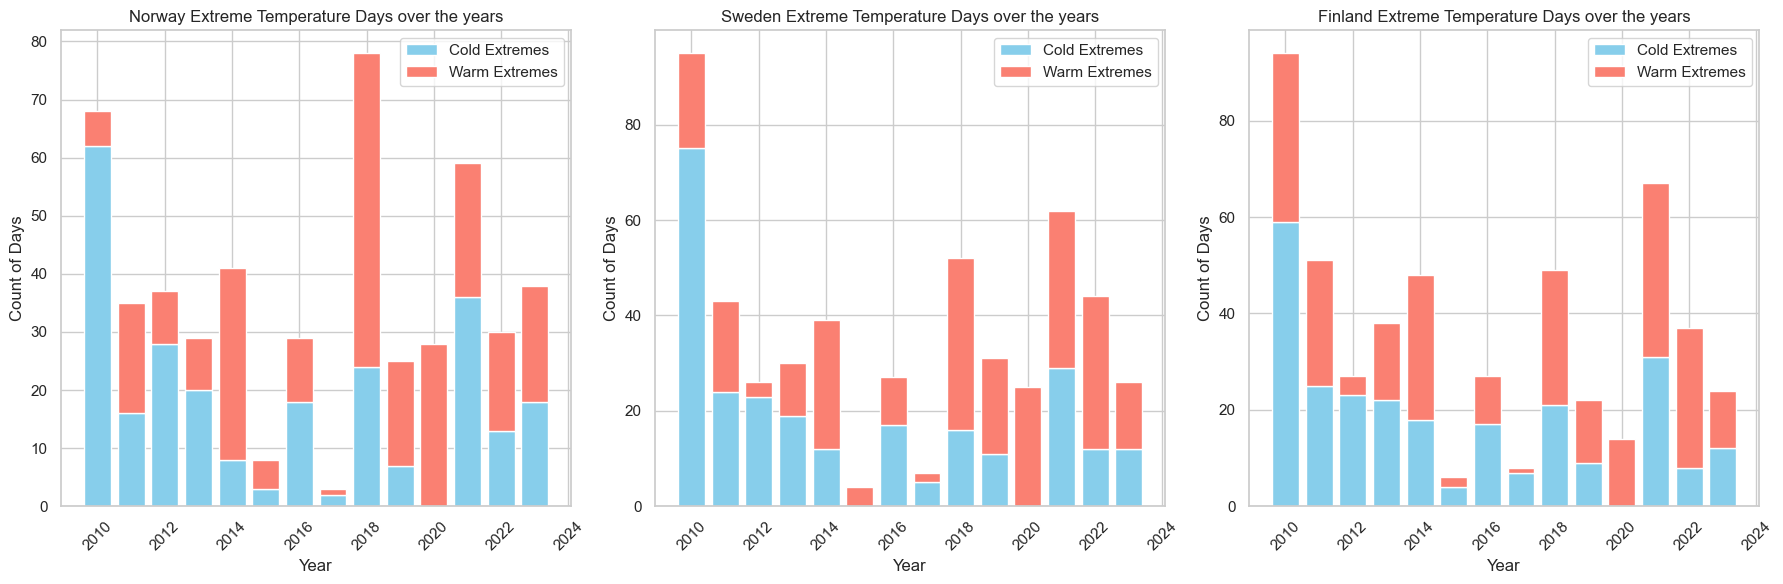

In [25]:
# Setting the figure size and layout
plt.figure(figsize=(18, 6))

# List of countries for iteration
countries = ['Norway', 'Sweden', 'Finland']

# Plotting a stacked bar chart for each country
for i, country in enumerate(countries):
    plt.subplot(1, 3, i+1)
    # Stacking cold and hot extremes
    plt.bar(extreme_temp_annual_breakdown.index, extreme_temp_annual_breakdown[f'{country}_Cold_Extremes'], color='skyblue', label='Cold Extremes')
    plt.bar(extreme_temp_annual_breakdown.index, extreme_temp_annual_breakdown[f'{country}_Warm_Extremes'], bottom=extreme_temp_annual_breakdown[f'{country}_Cold_Extremes'], color='salmon', label='Warm Extremes')
    
    plt.title(f'{country} Extreme Temperature Days over the years')
    plt.xlabel('Year')
    plt.ylabel('Count of Days')
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'plot6.png'), dpi = 600)  # Save as PNG format
plt.show()


In [26]:
# Assuming percentile values have been calculated and stored as follows:
percentile_values = {
    'Norway': {'5th': -10.77, '95th': 17.51},
    'Sweden': {'5th': -6.3, '95th': 19.85},
    'Finland': {'5th': -10.59, '95th': 19.14}
}

# Filter data above the 5th percentile for each country
above_5th_percentile = {
    country: df[f'Temp - {country}'][df[f'Temp - {country}'] > percentile_values[country]['5th']]
    for country in percentile_values
}

# Filter data above the 95th percentile for each country
above_95th_percentile = {
    country: df[f'Temp - {country}'][df[f'Temp - {country}'] > percentile_values[country]['95th']]
    for country in percentile_values
}


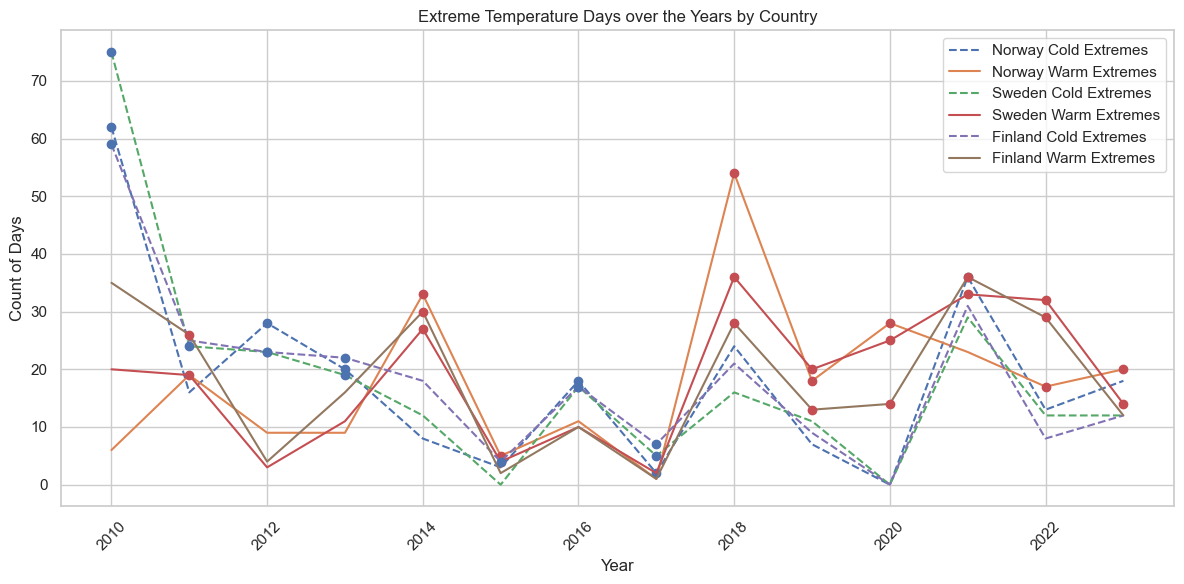

In [27]:

# Setting the figure size
plt.figure(figsize=(12, 6))

countries = ['Norway', 'Sweden', 'Finland']

# Plotting line charts for each country for cold and hot extremes separately
for country in countries:
    plt.plot(extreme_temp_annual_breakdown.index, extreme_temp_annual_breakdown[f'{country}_Cold_Extremes'], label=f'{country} Cold Extremes', linestyle='--')
    plt.plot(extreme_temp_annual_breakdown.index, extreme_temp_annual_breakdown[f'{country}_Warm_Extremes'], label=f'{country} Warm Extremes', linestyle='-')

    # Finding the indices where hot extremes exceed cold extremes
    warm_exceeds_cold_indices = extreme_temp_annual_breakdown.index[extreme_temp_annual_breakdown[f'{country}_Warm_Extremes'] > extreme_temp_annual_breakdown[f'{country}_Cold_Extremes']]
    
    # Marking those points with red dots
    plt.plot(warm_exceeds_cold_indices, extreme_temp_annual_breakdown.loc[warm_exceeds_cold_indices, f'{country}_Warm_Extremes'], 'ro')

    # Finding the indices where cold extremes exceed hot extremes
    cold_exceeds_warm_indices = extreme_temp_annual_breakdown.index[extreme_temp_annual_breakdown[f'{country}_Cold_Extremes'] > extreme_temp_annual_breakdown[f'{country}_Warm_Extremes']]
    
    # Marking those points with blue dots
    plt.plot(cold_exceeds_warm_indices, extreme_temp_annual_breakdown.loc[cold_exceeds_warm_indices, f'{country}_Cold_Extremes'], 'bo')

plt.title('Extreme Temperature Days over the Years by Country')
plt.xlabel('Year')
plt.ylabel('Count of Days')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'plotmean.png'), dpi = 600)  # Save as PNG format

plt.show()


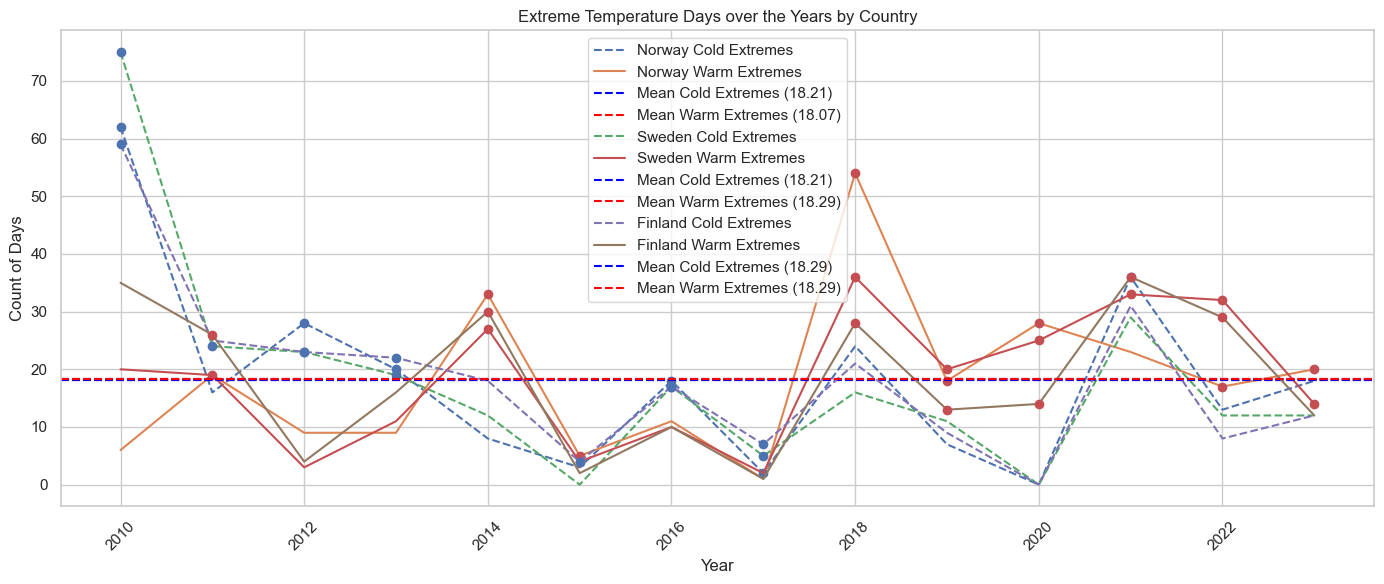

In [28]:
plt.figure(figsize=(14, 6))

countries = ['Norway', 'Sweden', 'Finland']

# Plotting line charts for each country for cold and hot extremes separately
for country in countries:
    plt.plot(extreme_temp_annual_breakdown.index, extreme_temp_annual_breakdown[f'{country}_Cold_Extremes'], label=f'{country} Cold Extremes', linestyle='--')
    plt.plot(extreme_temp_annual_breakdown.index, extreme_temp_annual_breakdown[f'{country}_Warm_Extremes'], label=f'{country} Warm Extremes', linestyle='-')

    # Finding the indices where hot extremes exceed cold extremes
    warm_exceeds_cold_indices = extreme_temp_annual_breakdown.index[extreme_temp_annual_breakdown[f'{country}_Warm_Extremes'] > extreme_temp_annual_breakdown[f'{country}_Cold_Extremes']]
    
    # Marking those points with red dots
    plt.plot(warm_exceeds_cold_indices, extreme_temp_annual_breakdown.loc[warm_exceeds_cold_indices, f'{country}_Warm_Extremes'], 'ro')
    
    # Finding the indices where cold extremes exceed hot extremes
    cold_exceeds_warm_indices = extreme_temp_annual_breakdown.index[extreme_temp_annual_breakdown[f'{country}_Cold_Extremes'] > extreme_temp_annual_breakdown[f'{country}_Warm_Extremes']]
    
    # Marking those points with blue dots
    plt.plot(cold_exceeds_warm_indices, extreme_temp_annual_breakdown.loc[cold_exceeds_warm_indices, f'{country}_Cold_Extremes'], 'bo')

    # Plotting mean extreme cold days as a straight line
    mean_cold = extreme_temp_annual_breakdown[f'{country}_Cold_Extremes'].mean()
    plt.axhline(y=mean_cold, color='blue', linestyle='--', label=f'Mean Cold Extremes ({mean_cold:.2f})')

    # Plotting mean extreme hot days as a straight line
    mean_warm = extreme_temp_annual_breakdown[f'{country}_Warm_Extremes'].mean()
    plt.axhline(y=mean_warm, color='red', linestyle='--', label=f'Mean Warm Extremes ({mean_warm:.2f})')

plt.title('Extreme Temperature Days over the Years by Country')
plt.xlabel('Year')
plt.ylabel('Count of Days')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(my_plots, 'plot7.png'), dpi = 600)  # Save as PNG format
plt.show()


#### LESS COLD EXTREMES NOW DUE TO GLOBAL WARMING MEANS LESS NEED FOR EXTENSIVE HEATING

In [29]:
df.describe()

,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Month,Year,Holiday_Norway,Holiday_Sweden,...,HDD_Finland,CDD_Norway,CDD_Sweden,CDD_Finland,Norway_Temp_Extremes,Sweden_Temp_Extremes,Finland_Temp_Extremes,Climate_Change_Norway,Climate_Change_Sweden,Climate_Change_Finland
count,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,...,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000
mean,14973.302758,15673.575396,9480.257188,4.625361,7.003264,5.398611,6.523372,2016.499707,0.010952,0.013691,...,12.772327,0.002265,0.024921,0.014068,0.148836,0.150010,0.150205,0.501467,0.504205,0.502836
std,3061.911246,3059.925444,1480.318052,8.894033,8.369215,9.321126,3.448919,4.031135,0.104090,0.116214,...,9.052522,0.057349,0.235543,0.144505,0.475070,0.477167,0.477310,0.500047,0.500031,0.500041
min,9414.000000,9982.000000,5863.000000,-24.020000,-18.950000,-26.350000,1.000000,2010.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12201.000000,13242.000000,8271.000000,-1.710000,0.550000,-0.950000,4.000000,2013.000000,0.000000,0.000000,...,4.490000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14690.000000,15273.000000,9319.000000,4.520000,6.450000,4.930000,7.000000,2016.000000,0.000000,0.000000,...,13.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,17564.000000,18015.000000,10529.000000,12.600000,14.310000,13.510000,10.000000,2020.000000,0.000000,0.000000,...,18.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,23297.000000,24420.000000,14298.000000,23.940000,26.110000,25.460000,12.000000,2023.000000,1.000000,1.000000,...,44.350000,1.940000,4.110000,3.460000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000


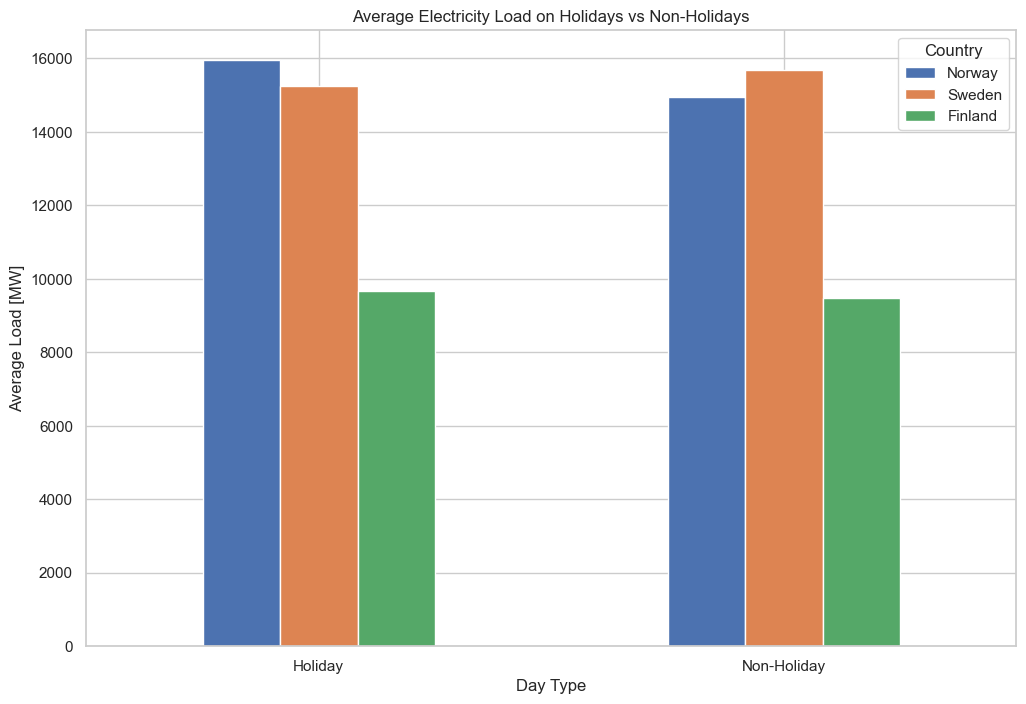

In [30]:
# Filtering data for holidays and calculating averages for holiday vs. non-holiday load
holiday_load_norway = df[df['Holiday_Norway'] == 1]['Total Load [MW] - Norway'].mean()
non_holiday_load_norway = df[df['Holiday_Norway'] == 0]['Total Load [MW] - Norway'].mean()

holiday_load_sweden = df[df['Holiday_Sweden'] == 1]['Total Load [MW] - Sweden'].mean()
non_holiday_load_sweden = df[df['Holiday_Sweden'] == 0]['Total Load [MW] - Sweden'].mean()

holiday_load_finland = df[df['Holiday_Finland'] == 1]['Total Load [MW] - Finland'].mean()
non_holiday_load_finland = df[df['Holiday_Finland'] == 0]['Total Load [MW] - Finland'].mean()

# Creating DataFrame for plotting
holiday_comparison = pd.DataFrame({
    'Norway': [holiday_load_norway, non_holiday_load_norway],
    'Sweden': [holiday_load_sweden, non_holiday_load_sweden],
    'Finland': [holiday_load_finland, non_holiday_load_finland]
}, index=['Holiday', 'Non-Holiday'])

# Plotting
# greens = ['#006400', '#008000', '#228B22', '#00FF00', '#ADFF2F']  
holiday_comparison.plot(kind='bar', figsize=(12, 8))
plt.title('Average Electricity Load on Holidays vs Non-Holidays')
plt.ylabel('Average Load [MW]')
plt.xlabel('Day Type')
plt.xticks(rotation=0)
plt.legend(title='Country')
plt.show()


In [31]:
# Extracting month and year before grouping
#df['Month'] = df['Load Date'].dt.month_name()
#df['Year'] = df['Load Date'].dt.year

# Grouping data by month and year for each country and computing the mean temperature
extreme_temps = df.groupby(['Month', 'Year']).agg({
    'Temp - Norway': 'mean',
    'Temp - Sweden': 'mean',
    'Temp - Finland': 'mean'
}).reset_index()

# Finding the record with the max and min temperatures for each country
norway_extremes = (extreme_temps.loc[extreme_temps['Temp - Norway'].idxmax()], extreme_temps.loc[extreme_temps['Temp - Norway'].idxmin()])
sweden_extremes = (extreme_temps.loc[extreme_temps['Temp - Sweden'].idxmax()], extreme_temps.loc[extreme_temps['Temp - Sweden'].idxmin()])
finland_extremes = (extreme_temps.loc[extreme_temps['Temp - Finland'].idxmax()], extreme_temps.loc[extreme_temps['Temp - Finland'].idxmin()])

# Assembling the results with month and year
extreme_months_with_years = {
    'Norway': {
        'Hottest': (norway_extremes[0]['Month'], norway_extremes[0]['Year']),
        'Coldest': (norway_extremes[1]['Month'], norway_extremes[1]['Year'])
    },
    'Sweden': {
        'Hottest': (sweden_extremes[0]['Month'], sweden_extremes[0]['Year']),
        'Coldest': (sweden_extremes[1]['Month'], sweden_extremes[1]['Year'])
    },
    'Finland': {
        'Hottest': (finland_extremes[0]['Month'], finland_extremes[0]['Year']),
        'Coldest': (finland_extremes[1]['Month'], finland_extremes[1]['Year'])
    }
}

extreme_months_with_years


{'Norway': {'Hottest': (7.0, 2018.0), 'Coldest': (12.0, 2010.0)},
 'Sweden': {'Hottest': (7.0, 2018.0), 'Coldest': (1.0, 2010.0)},
 'Finland': {'Hottest': (7.0, 2010.0), 'Coldest': (2.0, 2011.0)}}

In [32]:
# Define winter and summer months
winter_months = [12, 1, 2]  # December, January, February
summer_months = [6, 7, 8]   # June, July, August

# Filter data for winter and summer
winter_data = df[df['Month'].isin(winter_months)]
summer_data = df[df['Month'].isin(summer_months)]

# Calculate average temperatures for winter and summer
avg_winter_temps = winter_data.groupby(['Year', 'Month']).agg({
    'Temp - Norway': 'mean',
    'Temp - Sweden': 'mean',
    'Temp - Finland': 'mean'
}).reset_index()

avg_summer_temps = summer_data.groupby(['Year', 'Month']).agg({
    'Temp - Norway': 'mean',
    'Temp - Sweden': 'mean',
    'Temp - Finland': 'mean'
}).reset_index()

# Find the warmest winter and summer months for each country
warmest_winter_norway = avg_winter_temps.loc[avg_winter_temps['Temp - Norway'].idxmax()]
warmest_winter_sweden = avg_winter_temps.loc[avg_winter_temps['Temp - Sweden'].idxmax()]
warmest_winter_finland = avg_winter_temps.loc[avg_winter_temps['Temp - Finland'].idxmax()]

warmest_summer_norway = avg_summer_temps.loc[avg_summer_temps['Temp - Norway'].idxmax()]
warmest_summer_sweden = avg_summer_temps.loc[avg_summer_temps['Temp - Sweden'].idxmax()]
warmest_summer_finland = avg_summer_temps.loc[avg_summer_temps['Temp - Finland'].idxmax()]

(warmest_winter_norway, warmest_winter_sweden, warmest_winter_finland,
 warmest_summer_norway, warmest_summer_sweden, warmest_summer_finland)

(Year              2020.000000
 Month                1.000000
 Temp - Norway       -0.595161
 Temp - Sweden        2.406129
 Temp - Finland       0.927097
 Name: 30, dtype: float64,
 Year              2020.000000
 Month                1.000000
 Temp - Norway       -0.595161
 Temp - Sweden        2.406129
 Temp - Finland       0.927097
 Name: 30, dtype: float64,
 Year              2015.000000
 Month               12.000000
 Temp - Norway       -0.978065
 Temp - Sweden        1.930323
 Temp - Finland       1.320645
 Name: 17, dtype: float64,
 Year              2018.000000
 Month                7.000000
 Temp - Norway       19.661935
 Temp - Sweden       21.716452
 Temp - Finland      20.165806
 Name: 25, dtype: float64,
 Year              2018.000000
 Month                7.000000
 Temp - Norway       19.661935
 Temp - Sweden       21.716452
 Temp - Finland      20.165806
 Name: 25, dtype: float64,
 Year              2010.000000
 Month                7.000000
 Temp - Norway       16.0264

Warmest Winter Months:
Norway:
Year: 2020
Month: January
Average Temperature: -0.60°C
Sweden:
Year: 2020
Month: January
Average Temperature: 2.41°C
Finland:
Year: 2015
Month: December
Average Temperature: 1.32°C
Warmest Summer Months:
Norway:
Year: 2018
Month: July
Average Temperature: 19.66°C
Sweden:
Year: 2018
Month: July
Average Temperature: 21.72°C
Finland:
Year: 2010
Month: July
Average Temperature: 20.75°C

These results indicate that the warmest summer in recent years for Sweden and Norway was in July 2018, which correlates with a widespread heatwave reported across Europe during that period. Finland's warmest summer month from the dataset was July 2010. Similarly, January 2020 was notably warm for both Norway and Sweden during the winter season.

In [33]:
df

,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Day of Week,Month,Year,Holiday_Norway,...,CDD_Norway,CDD_Sweden,CDD_Finland,Norway_Temp_Extremes,Sweden_Temp_Extremes,Finland_Temp_Extremes,Climate_Change_Norway,Climate_Change_Sweden,Climate_Change_Finland,Season
Load Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,19067,19703,11427,-11.30,-7.62,-15.11,Friday,1,2010,1,...,0.0,0.0,0.0,1,1,1,0,0,0,Winter
2010-01-02,19566,20316,12129,-15.99,-9.00,-19.03,Saturday,1,2010,0,...,0.0,0.0,0.0,1,1,1,0,0,0,Winter
2010-01-03,19531,20844,11925,-14.84,-12.53,-15.06,Sunday,1,2010,0,...,0.0,0.0,0.0,1,1,1,0,0,0,Winter
2010-01-04,20426,21913,12250,-12.64,-12.80,-7.33,Monday,1,2010,0,...,0.0,0.0,0.0,1,1,0,0,0,0,Winter
2010-01-05,21402,23337,12726,-19.60,-16.35,-13.74,Tuesday,1,2010,0,...,0.0,0.0,0.0,1,1,1,0,0,0,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,20125,18863,10688,-8.08,-8.57,-7.20,Wednesday,12,2023,0,...,0.0,0.0,0.0,0,1,0,0,0,0,Winter
2023-12-28,20151,18044,10976,-8.64,-3.80,-4.25,Thursday,12,2023,0,...,0.0,0.0,0.0,0,0,0,0,0,1,Winter
2023-12-29,19551,17388,11279,-8.05,-0.20,-2.93,Friday,12,2023,0,...,0.0,0.0,0.0,0,0,0,0,1,1,Winter


In [34]:
df.columns

Index(['Total Load [MW] - Norway', 'Total Load [MW] - Sweden',
       'Total Load [MW] - Finland', 'Temp - Norway', 'Temp - Sweden',
       'Temp - Finland', 'Day of Week', 'Month', 'Year', 'Holiday_Norway',
       'Holiday_Sweden', 'Holiday_Finland', 'HDD_Norway', 'HDD_Sweden',
       'HDD_Finland', 'CDD_Norway', 'CDD_Sweden', 'CDD_Finland',
       'Norway_Temp_Extremes', 'Sweden_Temp_Extremes', 'Finland_Temp_Extremes',
       'Climate_Change_Norway', 'Climate_Change_Sweden',
       'Climate_Change_Finland', 'Season'],
      dtype='object')

In [35]:
# Calculate the overall mean temperatures for each country
mean_temp_norway = df['Temp - Norway'].mean()
mean_temp_sweden = df['Temp - Sweden'].mean()
mean_temp_finland = df['Temp - Finland'].mean()

# Create new columns to indicate climate change flags
df['Climate Change - Norway'] = df['Temp - Norway'] > mean_temp_norway
df['Climate Change - Sweden'] = df['Temp - Sweden'] > mean_temp_sweden
df['Climate Change - Finland'] = df['Temp - Finland'] > mean_temp_finland

# Print a sample of the DataFrame to see the new columns
print(df[['Temp - Norway', 'Climate Change - Norway', 'Temp - Sweden', 'Climate Change - Sweden', 'Temp - Finland', 'Climate Change - Finland']].head())


            Temp - Norway  Climate Change - Norway  Temp - Sweden  \
Load Date                                                           
2010-01-01         -11.30                    False          -7.62   
2010-01-02         -15.99                    False          -9.00   
2010-01-03         -14.84                    False         -12.53   
2010-01-04         -12.64                    False         -12.80   
2010-01-05         -19.60                    False         -16.35   

            Climate Change - Sweden  Temp - Finland  Climate Change - Finland  
Load Date                                                                      
2010-01-01                    False          -15.11                     False  
2010-01-02                    False          -19.03                     False  
2010-01-03                    False          -15.06                     False  
2010-01-04                    False           -7.33                     False  
2010-01-05                    False 

In [36]:
df

,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Day of Week,Month,Year,Holiday_Norway,...,Norway_Temp_Extremes,Sweden_Temp_Extremes,Finland_Temp_Extremes,Climate_Change_Norway,Climate_Change_Sweden,Climate_Change_Finland,Season,Climate Change - Norway,Climate Change - Sweden,Climate Change - Finland
Load Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,19067,19703,11427,-11.30,-7.62,-15.11,Friday,1,2010,1,...,1,1,1,0,0,0,Winter,False,False,False
2010-01-02,19566,20316,12129,-15.99,-9.00,-19.03,Saturday,1,2010,0,...,1,1,1,0,0,0,Winter,False,False,False
2010-01-03,19531,20844,11925,-14.84,-12.53,-15.06,Sunday,1,2010,0,...,1,1,1,0,0,0,Winter,False,False,False
2010-01-04,20426,21913,12250,-12.64,-12.80,-7.33,Monday,1,2010,0,...,1,1,0,0,0,0,Winter,False,False,False
2010-01-05,21402,23337,12726,-19.60,-16.35,-13.74,Tuesday,1,2010,0,...,1,1,1,0,0,0,Winter,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,20125,18863,10688,-8.08,-8.57,-7.20,Wednesday,12,2023,0,...,0,1,0,0,0,0,Winter,False,False,False
2023-12-28,20151,18044,10976,-8.64,-3.80,-4.25,Thursday,12,2023,0,...,0,0,0,0,0,1,Winter,False,False,False
2023-12-29,19551,17388,11279,-8.05,-0.20,-2.93,Friday,12,2023,0,...,0,0,0,0,1,1,Winter,False,False,False


In [37]:
df

,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Day of Week,Month,Year,Holiday_Norway,...,Norway_Temp_Extremes,Sweden_Temp_Extremes,Finland_Temp_Extremes,Climate_Change_Norway,Climate_Change_Sweden,Climate_Change_Finland,Season,Climate Change - Norway,Climate Change - Sweden,Climate Change - Finland
Load Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,19067,19703,11427,-11.30,-7.62,-15.11,Friday,1,2010,1,...,1,1,1,0,0,0,Winter,False,False,False
2010-01-02,19566,20316,12129,-15.99,-9.00,-19.03,Saturday,1,2010,0,...,1,1,1,0,0,0,Winter,False,False,False
2010-01-03,19531,20844,11925,-14.84,-12.53,-15.06,Sunday,1,2010,0,...,1,1,1,0,0,0,Winter,False,False,False
2010-01-04,20426,21913,12250,-12.64,-12.80,-7.33,Monday,1,2010,0,...,1,1,0,0,0,0,Winter,False,False,False
2010-01-05,21402,23337,12726,-19.60,-16.35,-13.74,Tuesday,1,2010,0,...,1,1,1,0,0,0,Winter,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,20125,18863,10688,-8.08,-8.57,-7.20,Wednesday,12,2023,0,...,0,1,0,0,0,0,Winter,False,False,False
2023-12-28,20151,18044,10976,-8.64,-3.80,-4.25,Thursday,12,2023,0,...,0,0,0,0,0,1,Winter,False,False,False
2023-12-29,19551,17388,11279,-8.05,-0.20,-2.93,Friday,12,2023,0,...,0,0,0,0,1,1,Winter,False,False,False


In [38]:
# saving df
#df.to_csv('nordext_df_clim.csv', index=True)

        Temp - Norway  Temp - Sweden  Temp - Finland
Season                                              
Fall         2.483736       5.278901        4.006374
Spring       2.717174       4.147391        3.203043
Summer      14.667609      17.334457       17.191739
Winter     -12.307111      -8.460667      -11.717444
            Total Load [MW] - Norway  Total Load [MW] - Sweden  \
Load Date                                                        
2010-01-01                     19067                     19703   
2010-01-02                     19566                     20316   
2010-01-03                     19531                     20844   
2010-01-04                     20426                     21913   
2010-01-05                     21402                     23337   

            Total Load [MW] - Finland  Temp - Norway  Temp - Sweden  \
Load Date                                                             
2010-01-01                      11427         -11.30          -7.62   
2010-0

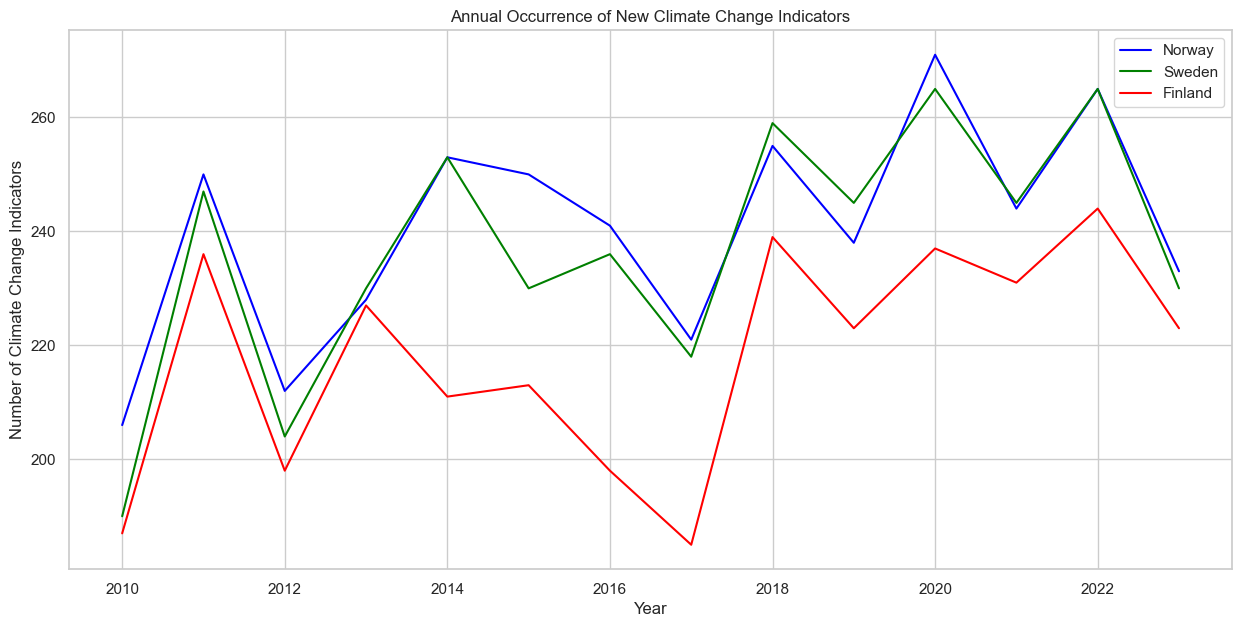

In [39]:

df.index.name = 'Load Date'

# Extracting the year and month from the index
df['Year'] = df.index.year
df['Month'] = df.index.month

# Defining the seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

# Filtering the DataFrame to include only 2010 data
df_2010 = df[df['Year'] == 2010]

# Calculating the mean temperatures for each season in 2010 for each country
# We explicitly select the numeric columns for this calculation
baseline_2010 = df_2010.groupby('Season').mean(numeric_only=True)[['Temp - Norway', 'Temp - Sweden', 'Temp - Finland']]
print(baseline_2010)

# Initializing new columns for climate change indicators based on the baseline
df['Climate_Change_Norway_New'] = 0
df['Climate_Change_Sweden_New'] = 0
df['Climate_Change_Finland_New'] = 0

# Function to determine if the temperature is higher than the 2010 baseline
def determine_climate_change(row, baseline):
    if row['Temp - Norway'] > baseline['Temp - Norway']:
        row['Climate_Change_Norway_New'] = 1
    if row['Temp - Sweden'] > baseline['Temp - Sweden']:
        row['Climate_Change_Sweden_New'] = 1
    if row['Temp - Finland'] > baseline['Temp - Finland']:
        row['Climate_Change_Finland_New'] = 1
    return row

# Applying the function to each row
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    baseline = baseline_2010.loc[season]
    df.loc[df['Season'] == season, ['Temp - Norway', 'Temp - Sweden', 'Temp - Finland', 'Climate_Change_Norway_New', 'Climate_Change_Sweden_New', 'Climate_Change_Finland_New']] = \
    df[df['Season'] == season].apply(lambda row: determine_climate_change(row, baseline), axis=1)

# Displaying the updated dataframe with the new climate change indicators
print(df.head())

# Calculating the annual sum of new climate change indicators for each country
annual_climate_change_indicators_new = df.groupby('Year').sum(numeric_only=True)[[
    'Climate_Change_Norway_New', 'Climate_Change_Sweden_New', 'Climate_Change_Finland_New'
]]


plt.figure(figsize=(15, 7))

plt.plot(annual_climate_change_indicators_new.index, annual_climate_change_indicators_new['Climate_Change_Norway_New'], label='Norway', color='blue')
plt.plot(annual_climate_change_indicators_new.index, annual_climate_change_indicators_new['Climate_Change_Sweden_New'], label='Sweden', color='green')
plt.plot(annual_climate_change_indicators_new.index, annual_climate_change_indicators_new['Climate_Change_Finland_New'], label='Finland', color='red')

plt.xlabel('Year')
plt.ylabel('Number of Climate Change Indicators')
plt.title('Annual Occurrence of New Climate Change Indicators')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
# Calculating the mean temperatures for each season in 2010 for each country
baseline_2010 = df[df['Year'] == 2010].groupby('Season').mean(numeric_only=True)[['Temp - Norway', 'Temp - Sweden', 'Temp - Finland']]
print(baseline_2010)

        Temp - Norway  Temp - Sweden  Temp - Finland
Season                                              
Fall         2.483736       5.278901        4.006374
Spring       2.717174       4.147391        3.203043
Summer      14.667609      17.334457       17.191739
Winter     -12.307111      -8.460667      -11.717444


In [41]:
# Calculating the mean temperatures for each season for each year
annual_means = df.groupby(['Year', 'Season']).mean(numeric_only=True)[['Temp - Norway', 'Temp - Sweden', 'Temp - Finland']]
annual_means

Temp - Norway  Temp - Sweden  Temp - Finland
Year Season                                              
2010 Fall         2.483736       5.278901        4.006374
     Spring       2.717174       4.147391        3.203043
     Summer      14.667609      17.334457       17.191739
     Winter     -12.307111      -8.460667      -11.717444
2011 Fall         6.337912       8.571758        7.764176
     Spring       4.244022       5.803152        3.517174
     Summer      15.173043      17.586739       17.742609
     Winter      -5.978778      -3.185333       -6.191889
2012 Fall         3.901978       6.900879        6.118462
     Spring       4.958152       5.490652        3.824674
     Summer      13.597065      15.468261       14.980109
     Winter      -7.839231      -4.370769       -7.646154
2013 Fall         5.068681       7.635385        6.628132
     Spring       2.251957       4.066304        1.904130
     Summer      14.571304      16.987826       16.721848
     Winter      -5.674444      -2.154556       -4.361444
2014 Fall         5.942527       8.402418        5.981868
     Spring       5.557174       6.062717        4.813370
     Summer      15.600109      16.963696       16.382717
     Winter      -4.206556      -1.307889       -4.142889
2015 Fall         5.480769       7.725165        6.825165
     Spring       3.826304       5.661196        4.334565
     Summer      13.671630      15.685000       14.831739
     Winter      -2.662889       0.104778       -1.371667
2016 Fall         4.687692       7.022527        4.524176
     Spring       4.901739       5.929457        5.214022
     Summer      14.793152      16.847065       15.775652
     Winter      -5.075385      -2.518901       -5.057143
2017 Fall         4.567253       7.306593        5.633297
     Spring       4.335000       5.154130        3.189457
     Summer      13.685217      16.214565       14.555000
     Winter      -4.432778      -1.671778       -3.133111
2018 Fall         5.471538       8.340989        7.071099
     Spring       3.652717       5.381087        3.930217
     Summer      16.499022      18.992935       17.331630
     Winter      -6.523333      -2.438444       -5.576778
2019 Fall         3.486593       7.310989        5.453956
     Spring       4.202609       5.583587        4.461848
     Summer      15.195326      17.643261       16.461957
     Winter      -4.672778      -1.322444       -3.465111
2020 Fall         6.564945       9.318571        7.859451
     Spring       4.124457       5.451087        4.060326
     Summer      15.285109      17.723804       16.308913
     Winter      -1.029560       1.990989       -0.177912
2021 Fall         6.065275       7.580440        5.878352
     Spring       3.734891       5.161957        3.686630
     Summer      16.137826      18.436630       17.962283
     Winter      -8.353333      -3.647111       -8.133333
2022 Fall         6.329560       8.533736        6.096703
     Spring       4.497065       5.355978        3.382174
     Summer      15.513152      18.560761       17.359457
     Winter      -5.155222      -2.093667       -4.276333
2023 Fall         3.635714       7.310879        5.610000
     Spring       2.841087       4.827826        3.965652
     Summer      15.666848      17.250000       16.652065
     Winter      -5.773667      -2.226000       -4.355667

In [42]:
# Calculating the deviations from the baseline for each season
deviations = annual_means.copy()

for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    baseline = baseline_2010.loc[season]
    deviations.loc[deviations.index.get_level_values('Season') == season, 'Temp - Norway'] -= baseline['Temp - Norway']
    deviations.loc[deviations.index.get_level_values('Season') == season, 'Temp - Sweden'] -= baseline['Temp - Sweden']
    deviations.loc[deviations.index.get_level_values('Season') == season, 'Temp - Finland'] -= baseline['Temp - Finland']

print(deviations.head())

             Temp - Norway  Temp - Sweden  Temp - Finland
Year Season                                              
2010 Fall         0.000000       0.000000        0.000000
     Spring       0.000000       0.000000        0.000000
     Summer       0.000000       0.000000        0.000000
     Winter       0.000000       0.000000        0.000000
2011 Fall         3.854176       3.292857        3.757802


In [43]:
df

,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Day of Week,Month,Year,Holiday_Norway,...,Climate_Change_Norway,Climate_Change_Sweden,Climate_Change_Finland,Season,Climate Change - Norway,Climate Change - Sweden,Climate Change - Finland,Climate_Change_Norway_New,Climate_Change_Sweden_New,Climate_Change_Finland_New
Load Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,19067,19703,11427,-11.30,-7.62,-15.11,Friday,1,2010,1,...,0,0,0,Winter,False,False,False,1,1,0
2010-01-02,19566,20316,12129,-15.99,-9.00,-19.03,Saturday,1,2010,0,...,0,0,0,Winter,False,False,False,0,0,0
2010-01-03,19531,20844,11925,-14.84,-12.53,-15.06,Sunday,1,2010,0,...,0,0,0,Winter,False,False,False,0,0,0
2010-01-04,20426,21913,12250,-12.64,-12.80,-7.33,Monday,1,2010,0,...,0,0,0,Winter,False,False,False,0,0,1
2010-01-05,21402,23337,12726,-19.60,-16.35,-13.74,Tuesday,1,2010,0,...,0,0,0,Winter,False,False,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,20125,18863,10688,-8.08,-8.57,-7.20,Wednesday,12,2023,0,...,0,0,0,Winter,False,False,False,1,0,1
2023-12-28,20151,18044,10976,-8.64,-3.80,-4.25,Thursday,12,2023,0,...,0,0,1,Winter,False,False,False,1,1,1
2023-12-29,19551,17388,11279,-8.05,-0.20,-2.93,Friday,12,2023,0,...,0,1,1,Winter,False,False,False,1,1,1


In [44]:
# saving df
#df.to_csv('nordext_df_climate.csv', index=True)